# Lab 2 - Naiwna klasyfikacja bayesowska i przetwarzanie języka naturalnego (NLP)

## Prawdopodobieństwo warunkowe

Prawdopodobieństwo warunkowe to wartość określająca szansę wystąpienia zdarzenia losowego A pod warunkiem
wystąpienia zdarzenia losowego B:

$$ P(A | B) = \frac{P(A \cap B)}{P(B)} $$

gdzie:
- $$ P(B) $$ oznacza prawdopodobieństwo wystąpienie zdarzenia losowego B
- $$ A \cap B $$ oznacza część wspólną zdarzeń losowych A i B
- $$ P(A \cap B) = \frac{|A \cap B|}{|A \cup B|} $$

co można przedstawić następująco w języku Python:

In [ ]:
import email
import io
import re
import pandas as pd
from collections import defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

a = {4, 6, 7}
b = {3, 6, 9}

a_and_b = a & b
a_or_b = a | b

p_a_and_b = len(a_and_b) / len(a_or_b)
p_b = len(b) / len(a_or_b)
p_a_if_b = p_a_and_b / p_b

print(f'Przestrzen zdarzen A: {a}')
print(f'Przestrzen zdarzen B: {b}')
print(f'Czesc wspolna zdarzen A i B: {a_and_b}')
print(f'Suma zdarzen A i B: {a_or_b}')
print(f'Prawdopodobienstwo czesci wspolnej zdarzen A i B: {p_a_and_b}')
print(f'Prawdopodobienstwo zdarzenia A pod warunkiem zajscia zdarzenia B: {p_a_if_b}')


## Naiwny klasyfikator bayesowski

Klasyfikator probabilistyczny, oparty na założeniu o wzajemnej niezależności atrybutów systemu decyzyjnego.

Wynik predykcji modelu jest prawdopodobieństwem warunkowym przynależności obiektu do klasy decyzyjnej $$ C $$ przy użyciu
atrybutów $$ A_1, A_2, ..., A_n $$, co można zdefiniować następująco:

$$ p(C | A_1, A_2, ... A_n) = \frac{p(C) p(A_1, A_2, ..., A_n | C)}{p(A_1, A_2, ..., A_n)} $$

## Przykład przydzielenia decyzji metodą Naiwnej Klasyfikacji Bayesowskiej

Rozważymy przykład Naiwnej Klasyfikacji Bayesowskiej na podstawie następującego systemu decyzyjnego zawierającego słowa,
 liczby ich wystąpień w danej klasie dokumentów tekstowych oraz etykietę klasy dokumentu:

| Słowo     | Liczba wystąpień | Klasa dokumentu          |
|-----------|------------------|--------------------------|
| witaj     | 10               | Wiadomość treściwa (ham) |
| promocja  | 35               | Spam                     |
| cześć     | 27               | Wiadomość treściwa (ham) |
| spotkanie | 6                | Wiadomość treściwa (ham) |
| oferta    | 42               | Spam                     |
| cześć     | 12               | Spam                     |
| witaj     | 21               | Spam                     |
| jira      | 35               | Wiadomość treściwa (ham) |
| projekt   | 42               | Wiadomość treściwa (ham) |
| zakupy    | 10               | Spam                     |

Rozważmy przykładowy tekst "witaj, jak twoje zaangażowanie w projekt?"

Każdemu słowu dopasujemy warunkowe prawdopodobieństwo wystąpienia dla każdej klasy decyzyjnej.
Pomijamy słowa krótsze niż 4 znaki.

| Słowo   | Prawdopodobieństwo wystąpienia w klasie           |
|---------|---------------------------------------------------|
| witaj   | P(witaj\|ham) = 10/120; P(witaj\|spam) = 21/120   |
| projekt | P(projekt\|ham) = 42/120; P(projekt\|spam) = 0    |

Mając ustalone prawdopodobieństwa wystąpienia słów w poszczególnych klasach decyzyjnych możemy przejść
do obliczenia estymaty bayesowskiej dla całego zdania wobec każdej klasy decyzyjnej, która pozwoli przydzielić decyzję.

W celu wyznaczenia estymaty bayesowskiej dla danej klasy decyzyjnej obliczamy iloczyn prawdopodobieństw wystąpienia
każdego słowa. Jeżeli dane słowo nie występuje, przydzielamy bardzo małe prawdopodobieństwo wystąpienia, np 0.00001.

- $$E_{ham} = \frac{10}{120} * 0.00001 * 0.00001 * 0.00001 * \frac{42}{120} = 2.9166667 * 10^{-17}$$
- $$E_{spam} = \frac{21}{120} * 0.00001 * 0.00001 * 0.00001 * 0.00001 = 1.75 * 10^{-21}$$

Estymata dla klasy wiadomości treściwych jest większa niż dla klasy spamu, zatem metodą
Naiwnej Klasyfikacji Bayesowskiej przydzielamy decyzję, że analizowany tekst jest wiadomością treściwą.

### Zadanie

Przydzielić decyzję metodą Naiwnej Klasyfikacji Bayesowskiej (na podstawie powyższego systemu decyzyjnego) następującym wiadomościom:
- "spotkanie się przedłużyło, jak wrócę to zrobię zakupy"
- "cześć john, w naszym sklepie czeka na ciebie specjalna oferta"
- "kiedy dotrzemy na lotnisko?"


## Tokenizacja

Jeden z najbardziej podstawowych etapów przetwarzania języka naturalnego, który polega na podziale
sekwencji słów (np. zdania) na mniejsze jednostki zwane tokenami (np. słowa lub znaki).

Przykładowa tokenizacja słów przy użyciu języka Python:

In [ ]:
seq = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua.'
tokens_ = re.findall('\w+', seq)

tokens_

## Budowa filtra spamu przy użyciu Naiwnego klasyfikatora bayesowskiego

Jest to jeden z najbardziej typowych przykładów zastosowania Naiwnego klasyfikatora bayesowskiego.
Do celów uczenia klasyfikatora zostanie wykorzystany zbiór maili CSDMC2010, który zawiera 4327 wiadomości, z następującym podziałem:
- 1378: spam
- 2949: nie spam

Zbiór wiadomości znajduje się w folderze data.

### Klasa EmailObject

Celem klasy jest parsowanie oryginalnych wiadomości e-mail (plik *.eml) w celu wyodrębnienia tematu oraz treści.
Te atrybuty są wystarczające w celu dokonania klasyfikacji.

In [ ]:
class EmailObject:
    def __init__(self, file, category=None):
        self.mail = email.message_from_file(file)
        self.category = category

    def subject(self):
        return self.mail.get('Subject')

    def body(self):
        content_type = self.mail.get_content_type()
        body = self.mail.get_payload(decode=False)

        if content_type == 'text/html':
            return BeautifulSoup(body, 'html.parser').text
        elif content_type == 'text/plain':
            return body
        else:
            return ''


email_obj0 = EmailObject(io.open('./data/TRAINING/TRAIN_00018.eml', 'r', encoding='latin-1'))

email_obj0.subject()

### Klasa Tokenizer

Celem klasy Tokenizer jest tokenizacja tekstu znajdującego się w wiadomości e-mail.

In [ ]:
class Tokenizer:
    NULL = u'\u0000'

    @staticmethod
    def tokenize(txt):
        return re.findall('\w+', txt.lower())

    @staticmethod
    def ngram(txt, n=2):
        s = txt.split(' ')
        result = []
        for i in range(1, n + 1):
            result.append([Tokenizer.NULL] * (n - i) + s)
        return list(zip(*result))

    @staticmethod
    def unique_tokenizer(txt):
        tokens = Tokenizer.tokenize(txt)
        return set(tokens)

seq = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua.'
tokens_ = Tokenizer.tokenize(seq)
three_grams = Tokenizer.ngram(seq, 3)

print(f'Tokens: {tokens_}\n3-grams: {three_grams}')


### Klasa SpamTrainer

Cele klasy są następujące:
- uczenie modelu
- klasyfikacja (przydzielanie decyzji)

Uczenie modelu będzie polegało na przechowywaniu liczebności słów występującej w każdej klasie decyzyjnej (spam/nie spam).
Zatem każde słowo będzie oddzielnym atrybutem w systemie treningowym.

In [ ]:
class SpamTrainer:
    def __init__(self, training_files):
        self.categories = set()

        for category, file in training_files:
            self.categories.add(category)

        self.totals = defaultdict(float)
        self.training = {c: defaultdict(float)
                         for c in self.categories}
        self.to_train = training_files

    def total_for(self, category):
        return self.totals[category]

    def train(self):
        for category, file in self.to_train:
            with open(file, 'r', encoding='latin-1') as f:
                mail = EmailObject(f)
            self.categories.add(category)

            for token in Tokenizer.unique_tokenizer(mail.body()):
                self.training[category][token] += 1
                self.totals['_all'] += 1
                self.totals[category] += 1

        self.to_train = {}

    def score(self, mail):
        self.train()
        cat_totals = self.totals

        aggregates = {c: cat_totals[c] / cat_totals['_all']
                      for c in self.categories}

        for token in Tokenizer.unique_tokenizer(mail.body()):
            for cat in self.categories:
                value = self.training[cat][token]
                r = (value + 1) / (cat_totals[cat] + 1)
                aggregates[cat] *= r

        return aggregates

    def normalized_score(self, mail):
        score = self.score(mail)
        scoresum = sum(score.values())

        normalized = {cat: (agg / scoresum)
                      for cat, agg in score.items()}

        return normalized

    def preference(self):
        return sorted(self.categories, key=lambda cat: self.total_for(cat))

    class Classification:
        def __init__(self, guess, score):
            self.guess = guess
            self.score = score

        def __eq__(self, other):
            return self.guess == other.guess and self.score == other.score

    def classify(self, mail):
        score = self.score(mail)

        max_score = 0.0
        preference = self.preference()
        max_key = preference[-1]

        for k, v in score.items():
            if v > max_score:
                max_key = k
                max_score = v
            elif v == max_score and preference.index(k) > preference.index(max_key):
                max_key = k
                max_score = v
        return self.Classification(max_key, max_score)

training_data_ = (
    ('ham', './data/TRAINING/TRAIN_00002.eml'),
    ('spam', './data/TRAINING/TRAIN_00000.eml'),
    ('ham', './data/TRAINING/TRAIN_00006.eml'),
    ('spam', './data/TRAINING/TRAIN_00003.eml'),
    ('ham', './data/TRAINING/TRAIN_00034.eml')
)

spam_trainer = SpamTrainer(training_data_)


email_obj0_classification_score = spam_trainer.classify(email_obj0)
print(f'Wynik klasyfikacji maila niebedacego spamem: {email_obj0_classification_score.guess}')

print('System treningowy utworzony w klasie SpamTrainer')
spam_trainer.training


### Walidacja modelu

W celu walidacji modelu zostaną zdefiniowane 3 funkcje pomocnicze.

Dodatkowo zostaną wykorzystane przygotowane podzbiory wiadomości e-mail wraz z etykietami (fold1, fold2).
Każdy z nich może być odpowiednikiem systemu treningowego i systemu testowego - są podzielone w stosunku 50%:50%.

W celu dokładniejszej walidacji modelu zostaną użyte dodatkowe miary wydajności klasyfikacji binarnej:
- FPR (False Positive Rate), odsetek obiektów, które zostały falszywie sklasyfikowane jako pozytywne: $$FPR = \frac{|False Positives|}{|total|}$$
- FNR (False Negative Rate), odsetek obiektów, które zostały falszywie sklasyfikowane jako negatywne: $$FNR = \frac{|False Negatives|}{|total|}$$

In [ ]:
def label_to_training_data(fold_file):
    """
    Funkcja zwraca wytrenowany model na wyznaczonym podzbiorze wiadomosci
    """

    training_data = []

    with open(fold_file, 'r') as f:
        for line in f:
            target, filepath = line.rstrip().split(' ')
            training_data.append([target, filepath])

    return SpamTrainer(training_data)


def parse_emails(keyfile):
    """
    Funkcja zwraca wyznaczony podzbior wiadomosci w postaci obiektow klasy EmailObject
    """

    emails = []

    with open(keyfile, 'r') as f:
        for line in f:
            label, file = line.rstrip().split(' ')

            with open(file, 'r', encoding='latin-1') as labelfile:
                emails.append(EmailObject(labelfile, category=label))

    return emails


def validate(trainer, set_of_emails):
    """
    Funkcja dokonuje walidacji wytrenowanego modelu (trainer)
    na podstawie zbioru oznaczonych wiadomosci (set_of_emails)
    """

    correct = 0
    false_positives = 0.0
    false_negatives = 0.0
    confidence = 0.0

    for mail in set_of_emails:
        classification = trainer.classify(mail)
        confidence += classification.score

        if classification.guess == 'spam' and mail.category == 'ham':
            false_positives += 1
        elif classification.guess == 'ham' and mail.category == 'spam':
            false_negatives += 1
        else:
            correct += 1

    total = false_positives + false_negatives + correct

    false_positive_rate = false_positives / total
    false_negative_rate = false_negatives / total
    error = (false_positives + false_negatives) / total

    return false_positive_rate, false_negative_rate, error


trainer = label_to_training_data('data/fold2.label')
emails = parse_emails('data/fold1.label')
fpr, fnr, err = validate(trainer, emails)

print(f'FPR: {fpr}, FNR: {fnr}, error: {err}, accuracy: {1 - err}')

In [ ]:
d1 = pd.read_csv('data/fold1.label', sep=' ', names=['class','name'])
d2 = pd.read_csv('data/fold2.label', sep=' ',names=['class','name'])

In [ ]:
d1=pd.DataFrame(d1)
d2=pd.DataFrame(d2)

In [9]:
data=pd.concat([d1,d2])

In [10]:
data=data.sample(frac=1)

In [11]:
import numpy as np


In [12]:
data.shape

(4327, 2)

In [13]:
data=data.reset_index()

In [14]:
data.drop('index', axis=1, inplace=True)

In [15]:
data.head()

,class,name
0,spam,./data/TRAINING/TRAIN_00744.eml
1,ham,./data/TRAINING/TRAIN_01410.eml
2,ham,./data/TRAINING/TRAIN_03988.eml
3,spam,./data/TRAINING/TRAIN_01330.eml
4,ham,./data/TRAINING/TRAIN_03179.eml


#### 55% system treningowy i 45% system testowy

In [16]:
train, test = np.split(data.sample(frac=1, random_state=1729), 
                                   [int(0.55 * len(data))])

In [17]:
print('Shape of train set:',train.shape)
print('Shape of test set:',test.shape)

Shape of train set: (2379, 2)
Shape of test set: (1948, 2)


In [18]:
train.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/train55', sep=' ' , index=False,header=False)
test.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/test45',sep=' ',index=False,header=False)

In [19]:
trainer55 = label_to_training_data('/Users/patrycjapiechowicz/ML/ML/lab2/data/train55')
emails45 = parse_emails('/Users/patrycjapiechowicz/ML/ML/lab2/data/test45')

In [20]:
fpr55_45, fnr55_45, err55_45 = validate(trainer55, emails45)
accuracy55_45=1 - err55_45
print(f'FPR: {fpr55_45}, FNR: {fnr55_45}, error: {err55_45}, accuracy: {1 - err55_45}')

FPR: 0.001540041067761807, FNR: 0.22176591375770022, error: 0.223305954825462, accuracy: 0.776694045174538


In [21]:
accuracy_55_45=1 - err55_45

#### 60% system treningowy i 40% system testowy

In [22]:
train, test = np.split(data.sample(frac=1, random_state=1720), 
                                   [int(0.6 * len(data))])

In [23]:
print('Shape of train set:',train.shape)
print('Shape of test set:',test.shape)

Shape of train set: (2596, 2)
Shape of test set: (1731, 2)


In [24]:
train.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/train60', sep=' ' , index=False,header=False)
test.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/test40',sep=' ',index=False,header=False)

In [25]:
trainer60 = label_to_training_data('/Users/patrycjapiechowicz/ML/ML/lab2/data/train60')
emails40 = parse_emails('/Users/patrycjapiechowicz/ML/ML/lab2/data/test40')

In [26]:
fpr, fnr, err = validate(trainer60, emails40)
accuracy60_40=1 - err
print(f'FPR: {fpr}, FNR: {fnr}, error: {err}, accuracy: {1 - err}')

FPR: 0.0005777007510109763, FNR: 0.22645869439630273, error: 0.2270363951473137, accuracy: 0.7729636048526863


#### 65% system treningowy i 35% system testowy

In [27]:
train, test = np.split(data.sample(frac=1, random_state=123), 
                                   [int(0.65 * len(data))])

In [28]:
print('Shape of train set:',train.shape)
print('Shape of test set:',test.shape)

Shape of train set: (2812, 2)
Shape of test set: (1515, 2)


In [29]:
train.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/train65', sep=' ' , index=False,header=False)
test.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/test35',sep=' ',index=False,header=False)

In [30]:
trainer65 = label_to_training_data('/Users/patrycjapiechowicz/ML/ML/lab2/data/train65')
emails35 = parse_emails('/Users/patrycjapiechowicz/ML/ML/lab2/data/test35')

In [31]:
fpr, fnr, err = validate(trainer65, emails35)
accuracy65_35=1 - err
print(f'FPR: {fpr}, FNR: {fnr}, error: {err}, accuracy: {1 - err}')

FPR: 0.0006600660066006601, FNR: 0.2132013201320132, error: 0.21386138613861386, accuracy: 0.7861386138613862


#### 70% system treningowy i 30% system testowy

In [32]:
train, test = np.split(data.sample(frac=1, random_state=1523), 
                                   [int(0.7 * len(data))])

In [33]:
print('Shape of train set:',train.shape)
print('Shape of test set:',test.shape)

Shape of train set: (3028, 2)
Shape of test set: (1299, 2)


In [34]:
train.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/train70', sep=' ' , index=False,header=False)
test.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/test30',sep=' ',index=False,header=False)

In [35]:
trainer70 = label_to_training_data('/Users/patrycjapiechowicz/ML/ML/lab2/data/train70')
emails30 = parse_emails('/Users/patrycjapiechowicz/ML/ML/lab2/data/test30')

In [36]:
fpr, fnr, err = validate(trainer70, emails30)
accuracy70_30=1 - err
print(f'FPR: {fpr}, FNR: {fnr}, error: {err}, accuracy: {1 - err}')

FPR: 0.0, FNR: 0.22555812163202463, error: 0.22555812163202463, accuracy: 0.7744418783679754


#### 75% system treningowy i 25% system testowy

In [37]:
train, test = np.split(data.sample(frac=1, random_state=1214), 
                                   [int(0.75 * len(data))])

In [38]:
print('Shape of train set:',train.shape)
print('Shape of test set:',test.shape)

Shape of train set: (3245, 2)
Shape of test set: (1082, 2)


In [39]:
train.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/train75', sep=' ' , index=False,header=False)
test.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/test25',sep=' ',index=False,header=False)

In [40]:
trainer75 = label_to_training_data('/Users/patrycjapiechowicz/ML/ML/lab2/data/train75')
emails25 = parse_emails('/Users/patrycjapiechowicz/ML/ML/lab2/data/test25')

In [41]:
fpr, fnr, err = validate(trainer75, emails25)
accuracy75_25=1 - err
print(f'FPR: {fpr}, FNR: {fnr}, error: {err}, accuracy: {1 - err}')

FPR: 0.0, FNR: 0.21719038817005545, error: 0.21719038817005545, accuracy: 0.7828096118299446


#### 80% system treningowy i 20% system testowy 

In [42]:
train, test = np.split(data.sample(frac=1, random_state=129), 
                                   [int(0.8 * len(data))])

In [43]:
print('Shape of train set:',train.shape)
print('Shape of test set:',test.shape)

Shape of train set: (3461, 2)
Shape of test set: (866, 2)


In [44]:
train.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/train80', sep=' ' , index=False,header=False)
test.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/test20',sep=' ',index=False,header=False)

In [45]:
trainer80 = label_to_training_data('/Users/patrycjapiechowicz/ML/ML/lab2/data/train80')
emails20 = parse_emails('/Users/patrycjapiechowicz/ML/ML/lab2/data/test20')

In [46]:
fpr, fnr, err = validate(trainer80, emails20)
accuracy80_20=1 - err
print(f'FPR: {fpr}, FNR: {fnr}, error: {err}, accuracy: {1 - err}')

FPR: 0.0, FNR: 0.22401847575057737, error: 0.22401847575057737, accuracy: 0.7759815242494226


#### Walidacja krzyżowa iteracja 1:

In [47]:
dane_cv= np.array_split(data.sample(frac=1),5)

In [48]:
3461+866, 865*5+2

(4327, 4327)

In [49]:
len(dane_cv)

5

In [50]:
print('Length of k=1',len(dane_cv[0]))
print('Length of k=2',len(dane_cv[1]))
print('Length of k=3',len(dane_cv[2]))
print('Length of k=4',len(dane_cv[3]))
print('Length of k=5',len(dane_cv[4]))


Length of k=1 866
Length of k=2 866
Length of k=3 865
Length of k=4 865
Length of k=5 865


In [51]:
train= pd.concat([dane_cv[1],dane_cv[2],dane_cv[3],dane_cv[4]])
test=dane_cv[0]

In [52]:
train.shape, test.shape

((3461, 2), (866, 2))

In [53]:
train.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/train_cv1', sep=' ' , index=False,header=False)
test.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/test_cv1',sep=' ',index=False,header=False)

In [54]:
trainer_cv1 = label_to_training_data('/Users/patrycjapiechowicz/ML/ML/lab2/data/train_cv1')
emails_cv1 = parse_emails('/Users/patrycjapiechowicz/ML/ML/lab2/data/test_cv1')

In [55]:
fpr_, fnr_, err = validate(trainer_cv1, emails_cv1)
accuracy_cv1=1 - err
print(f'FPR: {fpr}, FNR: {fnr}, error: {err}, accuracy: {1 - err}')

FPR: 0.0, FNR: 0.22401847575057737, error: 0.2390300230946882, accuracy: 0.7609699769053118


#### Walidacja krzyżowa iteracja 2:

In [56]:
train= pd.concat([dane_cv[0],dane_cv[2],dane_cv[3],dane_cv[4]])
test=dane_cv[1]

In [57]:
train.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/train_cv2', sep=' ' , index=False,header=False)
test.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/test_cv2',sep=' ',index=False,header=False)

In [58]:
trainer_cv2 = label_to_training_data('/Users/patrycjapiechowicz/ML/ML/lab2/data/train_cv2')
emails_cv2 = parse_emails('/Users/patrycjapiechowicz/ML/ML/lab2/data/test_cv2')

In [59]:
fpr, fnr, err = validate(trainer_cv2, emails_cv2)
accuracy_cv2=1 - err
print(f'FPR: {fpr}, FNR: {fnr}, error: {err}, accuracy: {1 - err}')

FPR: 0.0, FNR: 0.1951501154734411, error: 0.1951501154734411, accuracy: 0.8048498845265589


#### Walidacja krzyżowa iteracja 3:

In [60]:
train= pd.concat([dane_cv[0],dane_cv[1],dane_cv[3],dane_cv[4]])
test=dane_cv[2]

In [61]:
train.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/train_cv3', sep=' ' , index=False,header=False)
test.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/test_cv3',sep=' ',index=False,header=False)

In [62]:
trainer_cv3 = label_to_training_data('/Users/patrycjapiechowicz/ML/ML/lab2/data/train_cv3')
emails_cv3 = parse_emails('/Users/patrycjapiechowicz/ML/ML/lab2/data/test_cv3')

In [63]:
fpr, fnr, err = validate(trainer_cv3, emails_cv3)
accuracy_cv3=1 - err
print(f'FPR: {fpr}, FNR: {fnr}, error: {err}, accuracy: {1 - err}')

FPR: 0.0023121387283236996, FNR: 0.21271676300578035, error: 0.21502890173410405, accuracy: 0.784971098265896


#### Walidacja krzyżowa iteracja 4:

In [64]:
train= pd.concat([dane_cv[0],dane_cv[1],dane_cv[2],dane_cv[4]])
test=dane_cv[3]

In [65]:
train.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/train_cv4', sep=' ' , index=False,header=False)
test.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/test_cv4',sep=' ',index=False,header=False)

In [66]:
trainer_cv4 = label_to_training_data('/Users/patrycjapiechowicz/ML/ML/lab2/data/train_cv4')
emails_cv4 = parse_emails('/Users/patrycjapiechowicz/ML/ML/lab2/data/test_cv4')

In [67]:
fpr, fnr, err = validate(trainer_cv4, emails_cv4)
accuracy_cv4=1 - err
print(f'FPR: {fpr}, FNR: {fnr}, error: {err}, accuracy: {1 - err}')

FPR: 0.0, FNR: 0.19884393063583816, error: 0.19884393063583816, accuracy: 0.8011560693641618


#### Walidacja krzyżowa iteracja 5:

In [68]:
train= pd.concat([dane_cv[0],dane_cv[1],dane_cv[2],dane_cv[3]])
test=dane_cv[4]

In [69]:
train.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/train_cv5', sep=' ' , index=False,header=False)
test.to_csv(r'/Users/patrycjapiechowicz/ML/ML/lab2/data/test_cv5',sep=' ',index=False,header=False)

In [70]:
trainer_cv5 = label_to_training_data('/Users/patrycjapiechowicz/ML/ML/lab2/data/train_cv5')
emails_cv5 = parse_emails('/Users/patrycjapiechowicz/ML/ML/lab2/data/test_cv5')

In [71]:
fpr, fnr, err = validate(trainer_cv5, emails_cv5)
accuracy_cv5=1 - err
print(f'FPR: {fpr}, FNR: {fnr}, error: {err}, accuracy: {1 - err}')

FPR: 0.0011560693641618498, FNR: 0.23468208092485549, error: 0.23583815028901733, accuracy: 0.7641618497109827


In [72]:
accuracy_mean=np.mean([accuracy_cv1,accuracy_cv2,accuracy_cv3,accuracy_cv4,accuracy_cv5])

In [73]:
accuracy_mean

0.7832217757545822

#### Results:

In [74]:
names=['55% system treningowy i 45% system testowy','60% system treningowy i 40% system testowy','65% system treningowy i 35% system testowy','70% system treningowy i 30% system testowy','75% system treningowy i 25% system testowy','80% system treningowy i 20% system testowy','cross validation k=5']
accuracy=[accuracy55_45, accuracy60_40, accuracy65_35,accuracy70_30,accuracy75_25,accuracy80_20, accuracy_mean]

In [75]:
x,y=names, accuracy
results=pd.DataFrame(y,x)
columns=['accuracy']
results.columns=columns
results.sort_values('accuracy')

,accuracy
60% system treningowy i 40% system testowy,0.772964
70% system treningowy i 30% system testowy,0.774442
80% system treningowy i 20% system testowy,0.775982
55% system treningowy i 45% system testowy,0.776694
75% system treningowy i 25% system testowy,0.782810
cross validation k=5,0.783222
65% system treningowy i 35% system testowy,0.786139


In [76]:
columns=['accuracy']
results.columns=columns

In [77]:
results.sort_values('accuracy')

,accuracy
60% system treningowy i 40% system testowy,0.772964
70% system treningowy i 30% system testowy,0.774442
80% system treningowy i 20% system testowy,0.775982
55% system treningowy i 45% system testowy,0.776694
75% system treningowy i 25% system testowy,0.782810
cross validation k=5,0.783222
65% system treningowy i 35% system testowy,0.786139


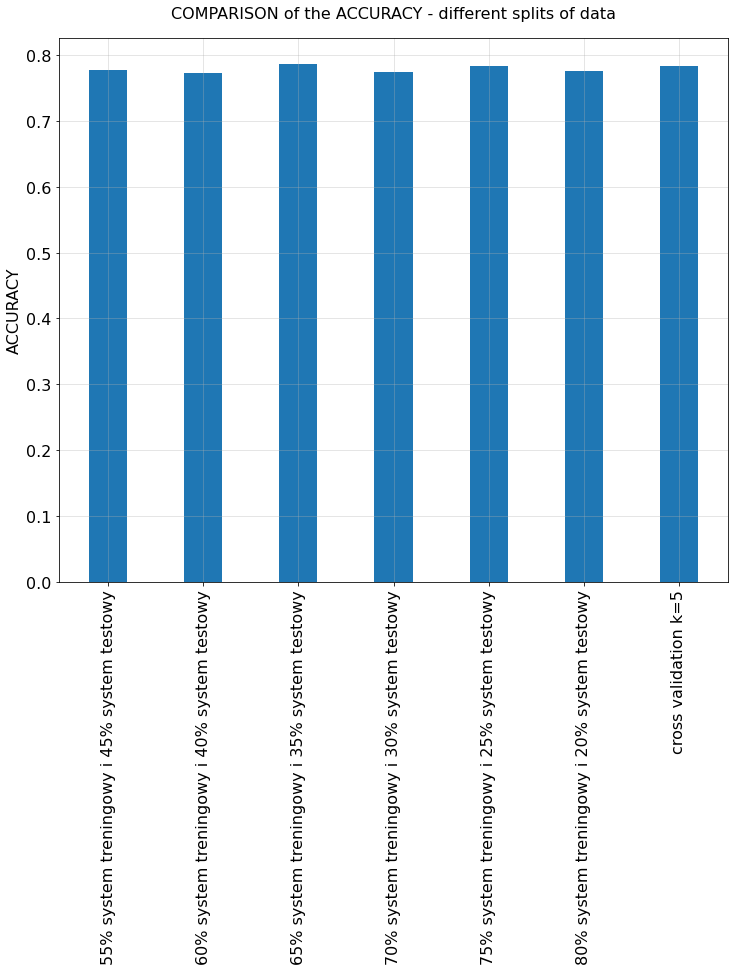

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12,10))
width = 0.4 # the width of the bars 
ind = np.arange(len(x))  # the x locations for the groups

plt.bar(x, y, width)
plt.xticks(ind, rotation=90, fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid(alpha=0.4)
plt.ylabel("ACCURACY", fontsize = 16)
plt.title("COMPARISON of the ACCURACY - different splits of data", fontsize = 16, pad = 20)  
plt.show()

Zadania:

1. Sprawdzić powyższe parametry klasyfikacji dla następujących podziałów wiadomości e-mail:
    - 55% system treningowy i 45% system testowy
    - 60% system treningowy i 40% system testowy
    - 65% system treningowy i 35% system testowy
    - 70% system treningowy i 30% system testowy
    - 75% system treningowy i 25% system testowy
    - 80% system treningowy i 20% system testowy
Dodatkowo, przy każdym podziale pomieszać kolejność wiadomości, zachowując jednocześnie przypisanie etykiet.
W tym celu należy przygotować odpowiedni skrypt tworzący pliki analogiczne do data/fold1.label i data/fold2.label

2. Sprawdzić działanie modelu na zbiorze maili SpamAssasin: https://spamassassin.apache.org/old/publiccorpus/
Wykorzystać 2 dowolne klasy decyzyjne.

3. Zaimplementować funkcjonalność walidacji krzyżowej w celu dokładnego zweryfikowania parametrów klasyfikacji.
Walidacja krzyżowa polega na podziale systemu treningowego na k fragmentów, gdzie k-1 fragmentów służy jako nowy system
treningowy, a pozostała część służy jako system testowy przeznaczony do oceny parametrów klasyfikacji modelu.
Cała operacja jest powtarzana k-krotnie, gdzie każdy z pierwotnie wyznaczonych k fragmentów musi zostać użyty
jako system treningowy dokładnie jeden raz. Końcowy wynik walidacji krzyżowej to uśrednione parametry klasyfikacji
ze wszystkich k iteracji wraz z odchyleniami standardowymi. Przykład dla 100 obiektów treningowych, gdzie k=5. System treningowy zostaje podzielony na
5 fragmentów (1, 2, 3, 4, 5), gdzie każdy liczy 20 obiektów. Dokonujemy 5 iteracji:
    - iteracja 1: system treningowy tworzą fragmenty 2, 3, 4, 5; system testowy tworzy fragment 1; dokładność klasyfikacji wynosi 80%
    - iteracja 2: system treningowy tworzą fragmenty 1, 3, 4, 5; system testowy tworzy fragment 2; dokładność klasyfikacji wynosi 85%
    - iteracja 3: system treningowy tworzą fragmenty 1, 2, 4, 5; system testowy tworzy fragment 3; dokładność klasyfikacji wynosi 91%
    - iteracja 4: system treningowy tworzą fragmenty 1, 2, 3, 5; system testowy tworzy fragment 4; dokładność klasyfikacji wynosi 87%
    - iteracja 5: system treningowy tworzą fragmenty 1, 2, 3, 4; system testowy tworzy fragment 5; dokładność klasyfikacji wynosi 90%
Wynik końcowy to uśredniony wynik parametrów ze wszystkich iteracji, zatem dokładność końcowa wynosi 86.6%, przy odchyleniu standardowym 3.93


## Klasyfikator bayesowski w pakiecie scikit-learn

Scikit-learn to jedna z najpopularniejszych bibliotek zawierających zaimplementowane klasyfikatory i regresory oraz popularne systemy decyzyjne.

### Przykład naiwnej klasyfikacji bayesowskiej przy użyciu biblioteki scikit-learn:

#### Wczytanie systemu decyzyjnego

In [81]:
df = pd.read_csv('data/data-bayes.csv')

df.head()

,glucose,bloodpressure,diabetes
0,40,85,0
1,40,92,0
2,45,63,1
3,45,80,0
4,40,73,1


#### Przygotowanie systemu decyzyjnego do klasyfikacji

Podział na atrybuty wejściowe (X) i decyzyjny (y) oraz na system treningowy i testowy w stosunku 75%:25%

In [82]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [83]:
X_train.head(n=3)

,glucose,bloodpressure
152,40,95
844,50,65
734,45,88


In [84]:
y_test.head(n=3)

348    1
380    1
361    1
Name: diabetes, dtype: int64

#### Utworzenie modelu i uczenie

In [85]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

#### Walidacja dokładności wytrenowanego modelu

In [86]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100

print(f'Dokladnosc wytrenowanego modelu: {acc}%')


Dokladnosc wytrenowanego modelu: 92.7710843373494%


#### Predykcja klasy decyzyjnej obiektu

In [87]:
id_ = 10

pred = model.predict([X_test.iloc[id_].tolist()])
original_decision = y_test.iloc[id_]

print(f'Przydzielona decyzja: {pred[0]}, oryginalna decyzja: {original_decision}')

Przydzielona decyzja: 0, oryginalna decyzja: 1


### Zadania

1. Korzystając ze źródła http://archive.ics.uci.edu/ml/datasets.php wybrać jeden system decyzyjny, a następnie dokonać
klasyfikacji metodą Naiwnej Klasyfikacji Bayesowskiej dowolnego atrybutu decyzyjnego. Wykorzystując rozwiązania zadań z regresji i klasyfikacji KNN,
sprawdzić wyniki na następujących podziałach systemów decyzyjnych:
    - 55% system treningowy i 45% system testowy
    - 60% system treningowy i 40% system testowy
    - 65% system treningowy i 35% system testowy
    - 70% system treningowy i 30% system testowy
    - 75% system treningowy i 25% system testowy

2. Porównać wyniki uzyskane w zadaniu 1 z klasyfikatorem KNN


In [88]:
df = pd.read_csv('/Users/patrycjapiechowicz/ML/ML/lab2/winequality-red (1).csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [89]:
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [90]:
X_train.head(n=3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1354,7.2,0.58,0.03,2.3,0.077,7.0,28.0,0.99568,3.35,0.52,10.0
296,10.6,0.83,0.37,2.6,0.086,26.0,70.0,0.99810,3.16,0.52,9.9
925,8.6,0.22,0.36,1.9,0.064,53.0,77.0,0.99604,3.47,0.87,11.0


In [91]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1199, 11), (400, 11), (1199,), (400,))

In [92]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [93]:
y_pred = model.predict(X_test)
acc_25 = accuracy_score(y_test, y_pred) * 100

print(f'Dokladnosc wytrenowanego modelu: {acc}%')


Dokladnosc wytrenowanego modelu: 92.7710843373494%


In [94]:
id_ = 10

pred = model.predict([X_test.iloc[id_].tolist()])
original_decision = y_test.iloc[id_]

print(f'Przydzielona decyzja: {pred[0]}, oryginalna decyzja: {original_decision}')

Przydzielona decyzja: 5, oryginalna decyzja: 6


#### 55% system treningowy i 45% system testowy

In [95]:
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.45)

In [96]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((879, 11), (720, 11), (879,), (720,))

In [97]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [98]:
y_pred = model.predict(X_test)
acc_45 = accuracy_score(y_test, y_pred) * 100

print(f'Dokladnosc wytrenowanego modelu: {acc}%')


Dokladnosc wytrenowanego modelu: 92.7710843373494%


In [99]:
id_ = 10

pred = model.predict([X_test.iloc[id_].tolist()])
original_decision = y_test.iloc[id_]

print(f'Przydzielona decyzja: {pred[0]}, oryginalna decyzja: {original_decision}')

Przydzielona decyzja: 7, oryginalna decyzja: 6


#### 65% system treningowy i 35% system testowy

In [100]:
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.35)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1039, 11), (560, 11), (1039,), (560,))

In [101]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [102]:
y_pred = model.predict(X_test)
acc_35 = accuracy_score(y_test, y_pred) * 100

print(f'Dokladnosc wytrenowanego modelu: {acc}%')


Dokladnosc wytrenowanego modelu: 92.7710843373494%


In [103]:
id_ = 10

pred = model.predict([X_test.iloc[id_].tolist()])
original_decision = y_test.iloc[id_]

print(f'Przydzielona decyzja: {pred[0]}, oryginalna decyzja: {original_decision}')

Przydzielona decyzja: 6, oryginalna decyzja: 6


#### 60% system treningowy i 40% system testowy

In [104]:
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.40)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((959, 11), (640, 11), (959,), (640,))

In [105]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [106]:
y_pred = model.predict(X_test)
acc_40 = accuracy_score(y_test, y_pred) * 100

print(f'Dokladnosc wytrenowanego modelu: {acc_40}%')


Dokladnosc wytrenowanego modelu: 55.78125000000001%


In [107]:
id_ = 10

pred = model.predict([X_test.iloc[id_].tolist()])
original_decision = y_test.iloc[id_]

print(f'Przydzielona decyzja: {pred[0]}, oryginalna decyzja: {original_decision}')

Przydzielona decyzja: 7, oryginalna decyzja: 7


#### 70% system treningowy i 30% system testowy

In [108]:
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1119, 11), (480, 11), (1119,), (480,))

In [109]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [110]:
y_pred = model.predict(X_test)
acc_30 = accuracy_score(y_test, y_pred) * 100

print(f'Dokladnosc wytrenowanego modelu: {acc}%')

Dokladnosc wytrenowanego modelu: 92.7710843373494%


In [111]:
id_ = 10

pred = model.predict([X_test.iloc[id_].tolist()])
original_decision = y_test.iloc[id_]

print(f'Przydzielona decyzja: {pred[0]}, oryginalna decyzja: {original_decision}')

Przydzielona decyzja: 4, oryginalna decyzja: 5


#### 75% system treningowy i 25% system testowy

In [112]:
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1199, 11), (400, 11), (1199,), (400,))

In [113]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [114]:
y_pred = model.predict(X_test)
acc_25 = accuracy_score(y_test, y_pred) * 100

print(f'Dokladnosc wytrenowanego modelu: {acc_25}%')

Dokladnosc wytrenowanego modelu: 54.0%


In [115]:
id_ = 10

pred = model.predict([X_test.iloc[id_].tolist()])
original_decision = y_test.iloc[id_]

print(f'Przydzielona decyzja: {pred[0]}, oryginalna decyzja: {original_decision}')

Przydzielona decyzja: 5, oryginalna decyzja: 5


In [116]:
names=['75% system treningowy i 25% system testowy','70% system treningowy i 30% system testowy','65% system treningowy i 35% system testowy','60% system treningowy i 40% system testowy','55% system treningowy i 45% system testowy']

In [117]:
accuracy

[0.776694045174538,
 0.7729636048526863,
 0.7861386138613862,
 0.7744418783679754,
 0.7828096118299446,
 0.7759815242494226,
 0.7832217757545822]

In [122]:
"""x,y=names, accuracy
results=pd.DataFrame(y,x)
columns=['accuracy']
results.columns=names
results.sort_values('accuracy')"""

"x,y=names, accuracy\nresults=pd.DataFrame(y,x)\ncolumns=['accuracy']\nresults.columns=names\nresults.sort_values('accuracy')"

In [123]:
"""import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(10,8))
width = 0.4 # the width of the bars 
ind = np.arange(len(x))  # the x locations for the groups

plt.bar(x, y, width)
plt.xticks(ind, rotation=90, fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid(alpha=0.4)
plt.ylabel("ACCURACY", fontsize = 16)
plt.title("COMPARISON of the ACCURACY - different splits of data", fontsize = 16, pad = 10)  
plt.show()"""

'import matplotlib.pyplot as plt\nimport numpy as np\nfig = plt.figure(figsize=(10,8))\nwidth = 0.4 # the width of the bars \nind = np.arange(len(x))  # the x locations for the groups\n\nplt.bar(x, y, width)\nplt.xticks(ind, rotation=90, fontsize = 12)\nplt.yticks(fontsize = 12)\nplt.grid(alpha=0.4)\nplt.ylabel("ACCURACY", fontsize = 16)\nplt.title("COMPARISON of the ACCURACY - different splits of data", fontsize = 16, pad = 10)  \nplt.show()'

In [124]:
df2 = pd.read_csv('data/data-bayes.csv')

df2.head()

,glucose,bloodpressure,diabetes
0,40,85,0
1,40,92,0
2,45,63,1
3,45,80,0
4,40,73,1


In [130]:
X = df2.drop('diabetes', axis=1)
y = df2['diabetes']

#### Walidacja krzyzowa 1

In [131]:
df2.shape

(995, 3)

In [166]:
dane_cv= np.array_split(df2.sample(frac=1),5)

In [167]:
len(dane_cv)

5

In [168]:
print('Length of k=1',len(dane_cv[0]))
print('Length of k=2',len(dane_cv[1]))
print('Length of k=3',len(dane_cv[2]))
print('Length of k=4',len(dane_cv[3]))
print('Length of k=5',len(dane_cv[4]))

Length of k=1 199
Length of k=2 199
Length of k=3 199
Length of k=4 199
Length of k=5 199


In [204]:
train= pd.concat([dane_cv[1],dane_cv[2],dane_cv[3],dane_cv[4]])
test=dane_cv[0]

In [205]:
train.shape, test.shape

((796, 3), (199, 3))

In [206]:
X_train = train.drop('diabetes', axis=1)
y_train = train['diabetes']

In [207]:
X_test = test.drop('diabetes', axis=1)
y_test = test['diabetes']

In [208]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [209]:
y_pred = model.predict(X_test)
acc1 = accuracy_score(y_test, y_pred) * 100

print(f'Dokladnosc wytrenowanego modelu: {acc1}%')


Dokladnosc wytrenowanego modelu: 92.96482412060301%


#### Walidacja krzyzowa 2

In [210]:
train= pd.concat([dane_cv[0],dane_cv[2],dane_cv[3],dane_cv[4]])
test=dane_cv[1]

In [176]:
train.shape, test.shape

((796, 3), (199, 3))

In [211]:
X_train = train.drop('diabetes', axis=1)
y_train = train['diabetes']

In [212]:
X_test = test.drop('diabetes', axis=1)
y_test = test['diabetes']

In [179]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [213]:
y_pred = model.predict(X_test)
acc2 = accuracy_score(y_test, y_pred) * 100

print(f'Dokladnosc wytrenowanego modelu: {acc2}%')


Dokladnosc wytrenowanego modelu: 91.4572864321608%


#### Walidacja krzyzowa 3


In [214]:
train= pd.concat([dane_cv[0],dane_cv[1],dane_cv[3],dane_cv[4]])
test=dane_cv[2]

In [215]:
train.shape, test.shape

((796, 3), (199, 3))

In [216]:
X_train = train.drop('diabetes', axis=1)
y_train = train['diabetes']

In [217]:
X_test = test.drop('diabetes', axis=1)
y_test= test['diabetes']

In [218]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [220]:
y_pred = model.predict(X_test)
acc3 = accuracy_score(y_test, y_pred) * 100

print(f'Dokladnosc wytrenowanego modelu: {acc3}%')


Dokladnosc wytrenowanego modelu: 94.9748743718593%


#### Walidacja krzyzowa 4

In [221]:
train= pd.concat([dane_cv[0],dane_cv[1],dane_cv[2],dane_cv[4]])
test=dane_cv[3]

In [222]:
X_train = train.drop('diabetes', axis=1)
y_train = train['diabetes']

In [223]:
X_test = test.drop('diabetes', axis=1)
y_test= test['diabetes']

In [224]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [236]:
y_pred = model.predict(X_test3)
acc4 = accuracy_score(y_test3, y_pred) * 100

print(f'Dokladnosc wytrenowanego modelu: {acc4}%')
print(f'STD wytrenowanego modelu: {np.std(acc4)}%')


Dokladnosc wytrenowanego modelu: 95.47738693467338%
STD wytrenowanego modelu: 0.0%


#### Walidacja krzyzowa 5

In [226]:
train= pd.concat([dane_cv[0],dane_cv[1],dane_cv[2],dane_cv[3]])
test=dane_cv[4]

In [227]:
X_train = train.drop('diabetes', axis=1)
y_train = train['diabetes']

In [228]:
X_test = test.drop('diabetes', axis=1)
y_test= test['diabetes']

In [229]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [235]:
y_pred = model.predict(X_test)
acc5 = accuracy_score(y_test, y_pred) * 100

print(f'Dokladnosc wytrenowanego modelu: {acc5}%')
print(f'STD wytrenowanego modelu: {np.std(acc5)}%')


Dokladnosc wytrenowanego modelu: 94.9748743718593%
STD wytrenowanego modelu: 0.0%


In [231]:
names=['cv1','cv2','cv3','cv4','cv5']
accuracy=[acc1,acc2,acc3,acc4,acc5]

In [232]:
x,y=names, accuracy
results=pd.DataFrame(y,x)
columns=['accuracy']
results.columns=columns
results.sort_values('accuracy')

,accuracy
cv2,91.457286
cv1,92.964824
cv3,94.974874
cv5,94.974874
cv4,95.477387


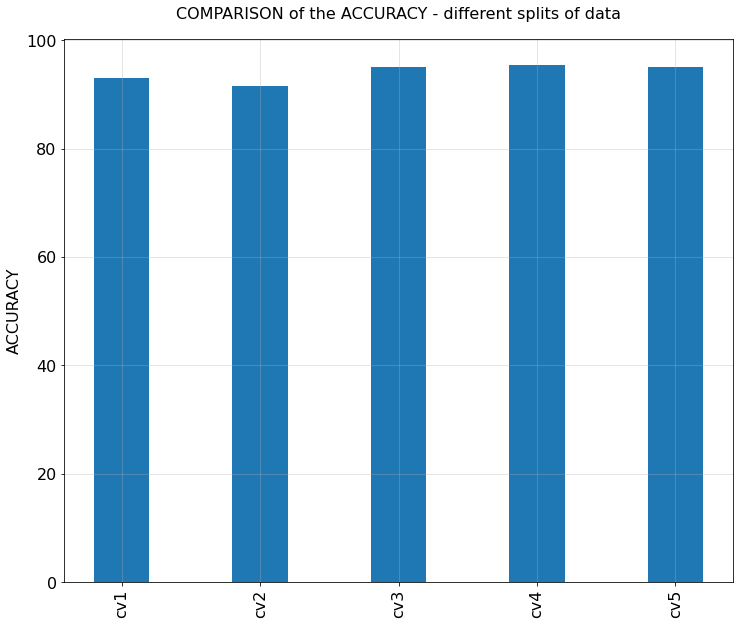

In [233]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12,10))
width = 0.4 # the width of the bars 
ind = np.arange(len(x))  # the x locations for the groups

plt.bar(x, y, width)
plt.xticks(ind, rotation=90, fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid(alpha=0.4)
plt.ylabel("ACCURACY", fontsize = 16)
plt.title("COMPARISON of the ACCURACY - different splits of data", fontsize = 16, pad = 20)  
plt.show()